<a href="https://colab.research.google.com/github/AnnaBujniewicz/semester_project/blob/main/5_Machine_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
import gensim
from datetime import datetime
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/ztakac18/M2-data/main/yf_chosen_comp.csv')
df=df.set_index(df['Date'], drop=True).drop('Date', 1)
df.index.name = 'date'
df.head()

,TSLA,GOOGL,ALXN,AMZN
date,,,,
2019-01-02,62.023998,1054.680054,98.050003,1539.130005
2019-01-03,60.071999,1025.469971,100.209999,1500.280029
2019-01-04,63.537998,1078.069946,106.000000,1575.390015
2019-01-07,66.991997,1075.920044,107.940002,1629.510010
2019-01-08,67.070000,1085.369995,108.610001,1656.579956


In [ ]:
df.describe()

,TSLA,GOOGL,ALXN,AMZN
count,482.000000,482.000000,482.000000,482.000000
mean,150.484585,1314.788153,112.941784,2190.069459
std,136.893149,178.166206,12.696327,568.962353
min,35.793999,1025.469971,75.559998,1500.280029
25%,51.438498,1170.785034,104.605000,1782.139984
50%,72.090000,1271.710022,111.680000,1898.270020
75%,187.864502,1451.832458,122.407499,2539.780029
max,585.760010,1787.020020,141.300003,3531.449951


#Tesla

In [ ]:
tsla=df.loc[:,['TSLA']]

In [ ]:
tsla=tsla.rename(columns={"TSLA": "close"})

In [ ]:
# creating a minmaxscaler instance

scaler = MinMaxScaler(feature_range=(0, 1))
# scaling the close column
tsla['close'] = scaler.fit_transform(tsla['close'].values.reshape(-1,1))

In [ ]:
# creating a new column in the dataframe that consists of the same values as the scaled close column
tsla["close-1"] = tsla["close"]
# shifting the column 1 days back since in practice in the investment strategy we will look at the next day development
tsla["close-1"] = tsla["close-1"].shift(1)
# inspecting the dataframe
tsla.head()

,close,close-1
date,,
2019-01-02,0.047694,NaN
2019-01-03,0.044145,0.047694
2019-01-04,0.050447,0.044145
2019-01-07,0.056727,0.050447
2019-01-08,0.056869,0.056727


In [ ]:
X_train_tsla = tsla["close-1"][1:int(len(tsla["close-1"])*0.8)]
X_test_tsla = tsla["close-1"][int(len(tsla["close-1"])*0.8):]
y_train_tsla = tsla["close"][1:int(len(tsla["close-1"])*0.8)]
y_test_tsla = tsla["close"][int(len(tsla["close-1"])*0.8):]

In [ ]:
# reshaping the train and test values
X_train_tsla = X_train_tsla.values.reshape(-1,1)
X_test_tsla = X_test_tsla.values.reshape(-1,1)
y_train_tsla = y_train_tsla.values.reshape(-1,1)

###2.1 Random Forest

In [ ]:
# creating a grid for the grid search for the random forest regressor
grid = {'n_estimators': list(range(10,101,10)),
               'max_features': ['auto', 'sqrt'],
               'max_depth': list(range(10,101,10)),
               'bootstrap': [True, False]}

In [ ]:
# creating a random forest regressor instance
rf = RandomForestRegressor()
# creating a grid search instance with 5 cross validation splits
search = GridSearchCV(rf, grid, cv=5)

In [ ]:
# fitting the search to the training set
search.fit(X_train_tsla, y_train_tsla)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
# printing out the best parameters and their score
print(search.best_params_)
print(search.best_score_)

{'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 40}
0.5830521719812758


In [ ]:
# creating a regression with the selected parameters
rf_tsla = RandomForestRegressor(bootstrap= True, max_depth = 10, max_features = "sqrt", n_estimators = 60)
# fitting it to the training set
rf_tsla.fit(X_train_tsla, y_train_tsla)
# predicting the values
y_pred_tsla_RF = rf_tsla.predict(X_test_tsla)

In [ ]:
# creating a new column in the dataframe
tsla["pred_RF"] = np.nan
# filling the column with the predicted values
tsla["pred_RF"][int(len(tsla["close-1"])*0.8):] = y_pred_tsla_RF

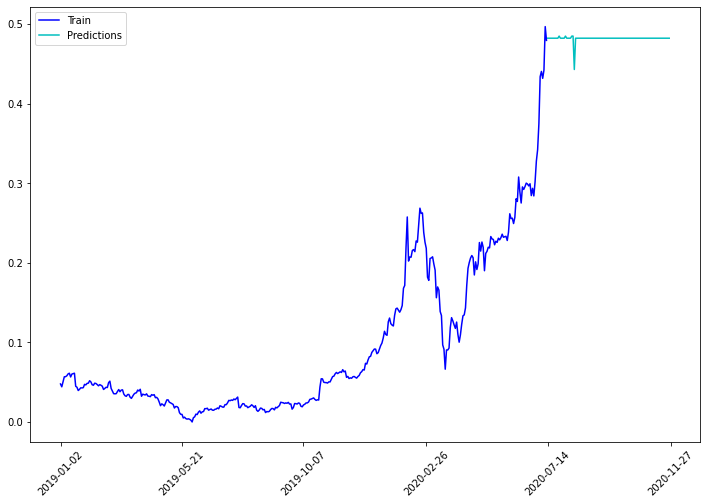

In [ ]:
# plotting the preddictions as appended to the training set - they seem not so good
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(tsla.close[:int(len(tsla["close-1"])*0.8)], color = "b")
plt.plot(tsla["pred_RF"][int(len(tsla["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

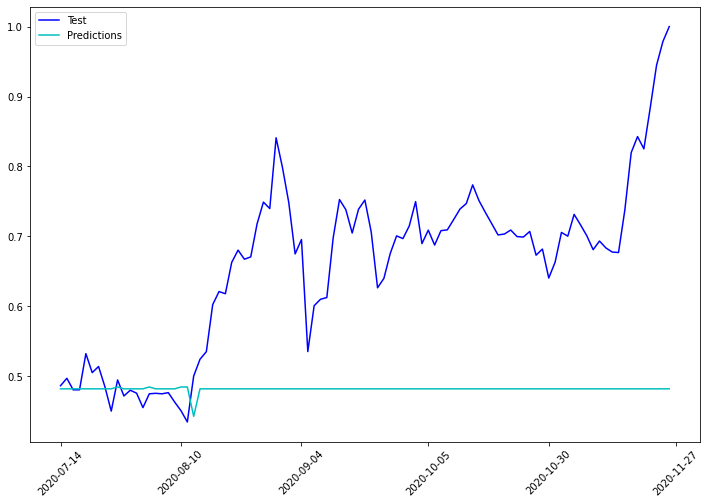

In [ ]:
# plotting the predictions and test data
#it seems that the model performs really bad
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_tsla, color = "b")
plt.plot(tsla["pred_RF"][int(len(tsla["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(tsla["pred_RF"][int(len(tsla["close-1"])*0.8):] - y_test_tsla)**2)

0.1773526515830449

##2.2 Linear Regression

In [ ]:
# creating a grid search
grid= {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [ ]:
# creating a linear regression instance
lr = LinearRegression()
# creating a grid search instance with 5 cross validation splits
search = GridSearchCV(lr, grid, cv=5)

In [ ]:
# fitting the grid search to the training data
search.fit(X_train_tsla, y_train_tsla)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# searching for the best parameters and inspecting the score
# the score improved
print(search.best_params_)
print(search.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.9119359460835458


In [ ]:
# creating a linear regression instance with the chosen parameters
lr = LinearRegression(copy_X= True, fit_intercept=True,normalize=True)
# fitting it to the training data
lr.fit(X_train_tsla, y_train_tsla)
# predicting the values
y_pred_tsla_LR = lr.predict(X_test_tsla)

In [ ]:
# creating a new column in the dataframe
tsla["pred_LR"] = np.nan
# filling it with the predictions
tsla["pred_LR"][int(len(tsla["close-1"])*0.8):] = np.array(y_pred_tsla_LR).squeeze(1)

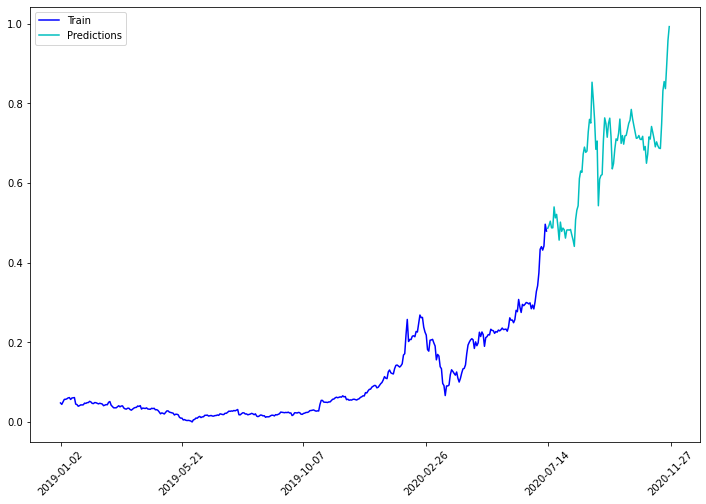

In [ ]:
# plotting the predictions as appended to the training data
# it can be noticed that the linear regression basically copied the last 25 days (so the training data)
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(tsla.close[:int(len(tsla["close-1"])*0.8)], color = "b")
plt.plot(tsla["pred_LR"][int(len(tsla["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

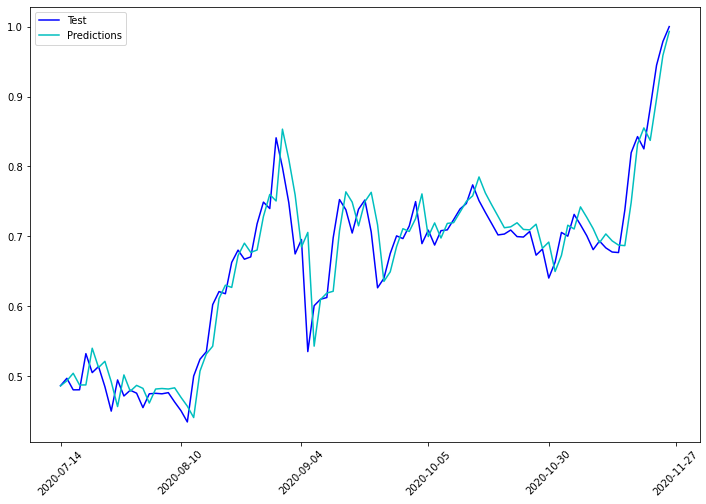

In [ ]:
# plotting the predictions and the test data
# here the values are similar and the curve is following the same shape
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_tsla, color = "b")
plt.plot(tsla["pred_LR"][int(len(tsla["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(tsla["pred_LR"][int(len(tsla["close-1"])*0.8):] - y_test_tsla)**2)

0.0041866073353975745

##3 Neural network for stock predictions

In [ ]:
# reshaping it again to make sure the dimensions are right for the network
X_train_tsla = np.reshape(X_train_tsla, (X_train_tsla.shape[0], 1, 1))
X_test_tsla = np.reshape(X_test_tsla, (X_test_tsla.shape[0], 1, 1))

In [ ]:
# creating a sequential model
model = Sequential()
# adding the firs tLSTM layer with 128 neurons, 0.2 dropout and recurrent dropout and return_sequences = True (to connect another LSTM layer)
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (1,1)))
# adding another LSTM layer - this time 64 neurons and no returning sequences
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# adding a dropout layer with 0.5 dropout rate
model.add(layers.Dropout(0.5))
# adding a dense layer with 128 neurons
model.add(layers.Dense(128, activation = "relu"))
# adding a dense layer with 64 neurons
model.add(layers.Dense(64, activation = "relu"))
# adding another dropout layer, this time just 0.2 dropout rate
model.add(layers.Dropout(0.2))
# adding the output layer with one neuron
model.add(layers.Dense(1))

In [ ]:
# viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [ ]:
# creating an early stopping monitor with the patience of 5 periods
stop = EarlyStopping(monitor = "loss", patience = 5, mode = "min", restore_best_weights=True)
# changing the learning rate of the optimizer
opt = optimizers.Adam(learning_rate=0.001)

In [ ]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
# fitting the model with the batch size of 1 and 50 epochs
history_tsla = model.fit(X_train_tsla, y_train_tsla, epochs=50, batch_size=1, verbose=1, callbacks = [stop])

Epoch 1/50
384/384 [==============================] - 5s 5ms/step - loss: 0.0069
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0059
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0036
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0034
Epoch 5/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0045
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0043
Epoch 7/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0022
Epoch 8/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0036
Epoch 9/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0016
Epoch 10/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0031
Epoch 11/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0024
Epoch 12/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0037
Epoch 13/50
384/384 [====

In [ ]:
# predicting the data
y_pred_tsla_N = model.predict(X_test_tsla)

In [ ]:
# creating an empty column
tsla["pred_N"] = np.nan
# filling it with the predictions
tsla["pred_N"][int(len(tsla["close-1"])*0.8):] = np.array(y_pred_tsla_N).squeeze(1)

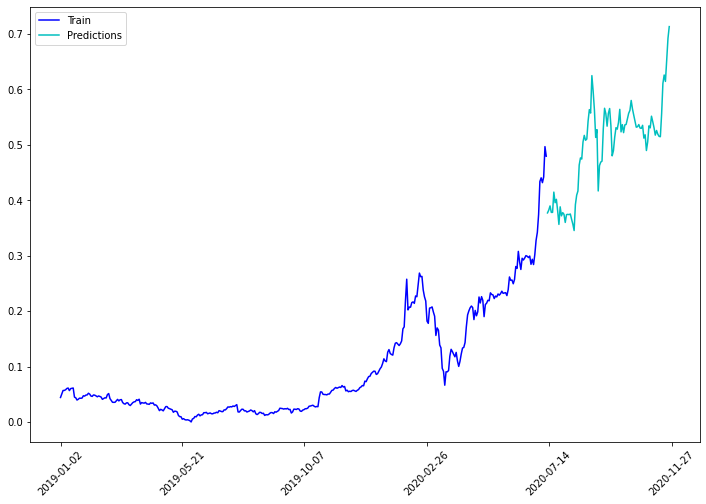

In [ ]:
# plotting the predictions as appended to the training set
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(tsla.close[1:int(len(tsla["close-1"])*0.8)], color = "b")
plt.plot(tsla["pred_N"][int(len(tsla["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

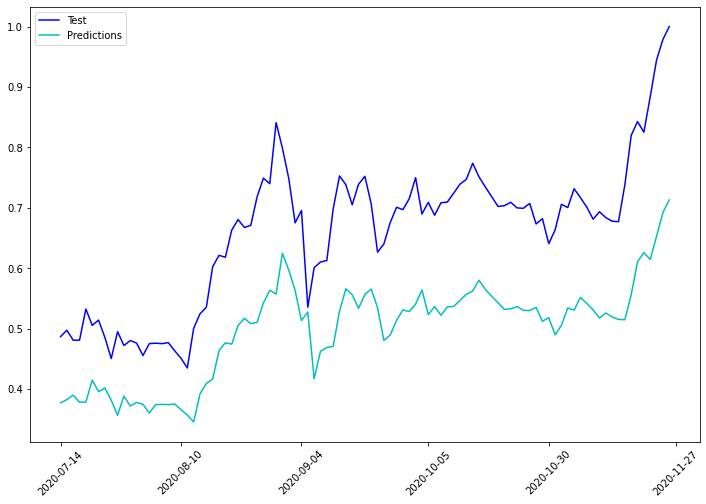

In [ ]:
# plotting the predictions and the test data
# the curves are rather similar
# the model seems to folow the same curve but it is pusshed downwords
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_tsla, color = "b")
plt.plot(tsla["pred_N"][int(len(tsla["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
# checking the mean squared error
np.sqrt(np.mean(tsla["pred_N"][int(len(tsla["close-1"])*0.8):] - y_test_tsla)**2)

0.16139313168124395

#Google

In [ ]:
googl=df.loc[:,['GOOGL']]

In [ ]:
googl=googl.rename(columns={"GOOGL": "close"})

In [ ]:
# creating a minmaxscaler instance
scaler = MinMaxScaler(feature_range=(0, 1))
# scaling the close column
googl['close'] = scaler.fit_transform(googl['close'].values.reshape(-1,1))

In [ ]:
# creating a new column in the dataframe that consists of the same values as the scaled close column
googl["close-1"] = googl["close"]
# shifting the column 1 days back 
googl["close-1"] = googl["close-1"].shift(1)
# inspecting the dataframe
googl.head()

,close,close-1
date,,
2019-01-02,0.038356,NaN
2019-01-03,0.000000,0.038356
2019-01-04,0.069070,0.000000
2019-01-07,0.066247,0.069070
2019-01-08,0.078655,0.066247


In [ ]:
# creating a train and test split (this time using 80% of the data for training)
X_train_googl = googl["close-1"][1:int(len(googl["close-1"])*0.8)]
X_test_googl = googl["close-1"][int(len(googl["close-1"])*0.8):]
y_train_googl = googl["close"][1:int(len(googl["close-1"])*0.8)]
y_test_googl = googl["close"][int(len(googl["close-1"])*0.8):]

In [ ]:
# reshaping the train and test values
X_train_googl = X_train_googl.values.reshape(-1,1)
X_test_googl = X_test_googl.values.reshape(-1,1)
y_train_googl = y_train_googl.values.reshape(-1,1)

##2.1 Random Forest

In [ ]:
# creating a grid for the grid search for the random forest regressor
grid_googl = {'n_estimators': list(range(10,101,10)),
               'max_features': ['auto', 'sqrt'],
               'max_depth': list(range(10,101,10)),
               'bootstrap': [True, False]}

In [ ]:
# creating a random forest regressor instance
rf_googl = RandomForestRegressor()
# creating a grid search instance with 5 cross validation splits
search_googl = GridSearchCV(rf_googl, grid_googl, cv=5)

In [ ]:
# fitting the search to the training set
search_googl.fit(X_train_googl, y_train_googl)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
# printing out the best parameters and their score
# the score is really bad
print(search.best_params_)
print(search.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.9119359460835458


In [ ]:
# creating a regression with the selected parameters
rf_googl = RandomForestRegressor(bootstrap= True, max_depth = 10, max_features = "sqrt", n_estimators = 60)
# fitting it to the training set
rf_googl.fit(X_train_googl, y_train_googl)
# predicting the values
y_pred_googl_RF = rf_googl.predict(X_test_googl)

In [ ]:
# creating a new column in the dataframe
googl["pred_RF"] = np.nan
# filling the column with the predicted values
googl["pred_RF"][int(len(googl["close-1"])*0.8):] = y_pred_googl_RF

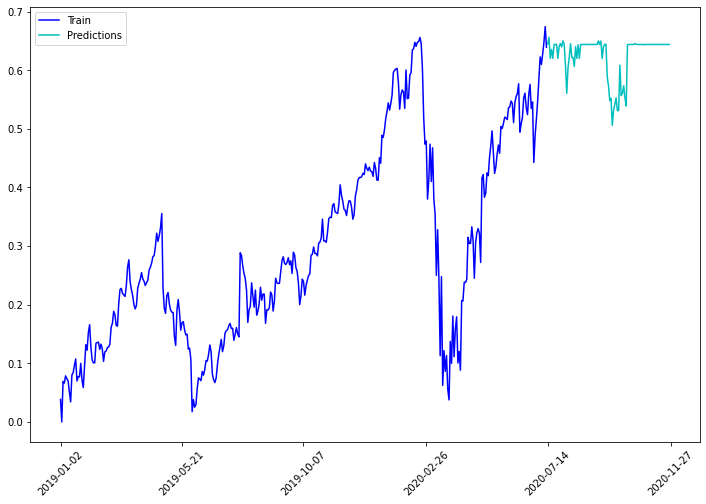

In [ ]:
# plotting the preddictions as appended to the training set
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(googl.close[:int(len(googl["close-1"])*0.8)], color = "b")
plt.plot(googl["pred_RF"][int(len(googl["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

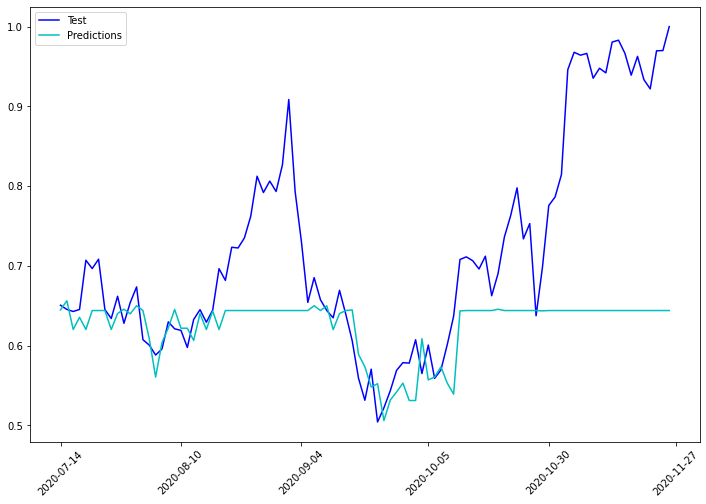

In [ ]:
# plotting the predictions and test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_googl, color = "b")
plt.plot(googl["pred_RF"][int(len(googl["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(googl["pred_RF"][int(len(googl["close-1"])*0.8):] - y_test_googl)**2)

0.09422038482266866

##2.2 Linear Regression

In [ ]:
# creating a grid search
grid_googl = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [ ]:
# creating a linear regression instance
lr_googl = LinearRegression()
# creating a grid search instance with 5 cross validation splits
search_googl = GridSearchCV(lr_googl, grid_googl, cv=5)

In [ ]:
# fitting the grid search to the training data
search_googl.fit(X_train_googl, y_train_googl)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# searching for the best parameters and inspecting the score
print(search.best_params_)
print(search.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.9119359460835458


In [ ]:
# creating a linear regression instance with the chosen parameters
lr_googl = LinearRegression(copy_X= True, fit_intercept=True,normalize=True)
# fitting it to the training data
lr_googl.fit(X_train_googl, y_train_googl)
# predicting the values
y_pred_googl_LR = lr_googl.predict(X_test_googl)

In [ ]:
# creating a new column in the dataframe
googl["pred_LR"] = np.nan
# filling it with the predictions
googl["pred_LR"][int(len(googl["close-1"])*0.8):] = np.array(y_pred_googl_LR).squeeze(1)

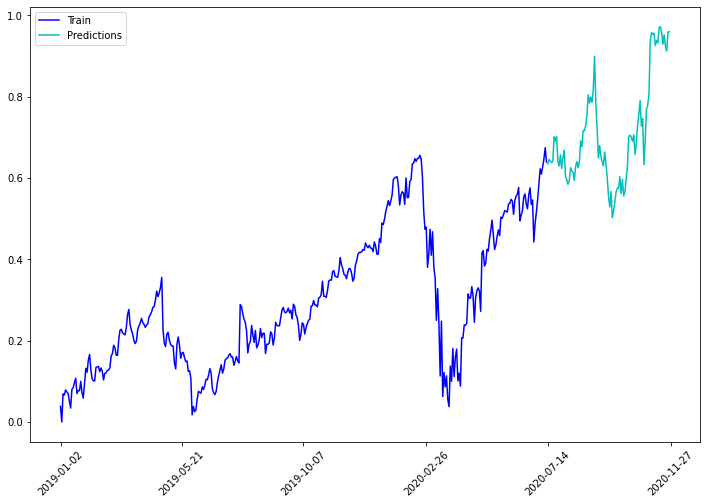

In [ ]:
# plotting the predictions as appended to the training data
# it can be noticed that the linear regression basically copied the last 25 days (so the training data)
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(googl.close[:int(len(googl["close-1"])*0.8)], color = "b")
plt.plot(googl["pred_LR"][int(len(googl["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

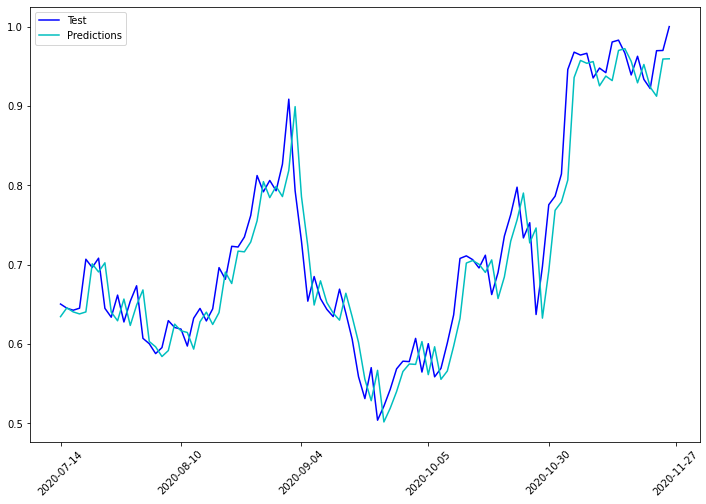

In [ ]:
# plotting the predictions and the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_googl, color = "b")
plt.plot(googl["pred_LR"][int(len(googl["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(googl["pred_LR"][int(len(googl["close-1"])*0.8):] - y_test_googl)**2)

0.009666545879755297

##3 Neural network for stock predictions

In [ ]:
# reshaping it again to make sure the dimensions are right for the network
X_train_googl = np.reshape(X_train_googl, (X_train_googl.shape[0], 1, 1))
X_test_googl = np.reshape(X_test_googl, (X_test_googl.shape[0], 1, 1))

In [ ]:
# creating a sequential model
model_googl = Sequential()
# adding the firs tLSTM layer with 128 neurons, 0.2 dropout and recurrent dropout and return_sequences = True (to connect another LSTM layer)
model_googl.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (1,1)))
# adding another LSTM layer - this time 64 neurons and no returning sequences
model_googl.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# adding a dropout layer with 0.5 dropout rate
model_googl.add(layers.Dropout(0.5))
# adding a dense layer with 128 neurons
model_googl.add(layers.Dense(128, activation = "relu"))
# adding a dense layer with 64 neurons
model_googl.add(layers.Dense(64, activation = "relu"))
# adding another dropout layer, this time just 0.2 dropout rate
model_googl.add(layers.Dropout(0.2))
# adding the output layer with one neuron
model_googl.add(layers.Dense(1))

In [ ]:
# viewing the summary of the model
model_googl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 128)            66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
# creating an early stopping monitor with the patience of 5 periods
stop_googl = EarlyStopping(monitor = "loss", patience = 5, mode = "min", restore_best_weights=True)
# changing the learning rate of the optimizer
opt_googl = optimizers.Adam(learning_rate=0.001)

In [ ]:
# compiling the model
model_googl.compile(loss='mean_squared_error', optimizer=opt_googl)

In [ ]:
# fitting the model with the batch size of 1 and 50 epochs
history_googl = model_googl.fit(X_train_googl, y_train_googl, epochs=50, batch_size=1, verbose=1, callbacks = [stop_googl])

Epoch 1/50
384/384 [==============================] - 5s 4ms/step - loss: 0.0351
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0126
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0153
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0119
Epoch 5/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0152
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0083
Epoch 7/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 8/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0113
Epoch 9/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0118
Epoch 10/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0083
Epoch 11/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0124
Epoch 12/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0099
Epoch 13/50
384/384 [====

In [ ]:
# predicting the data
y_pred_googl_N = model_googl.predict(X_test_googl)

In [ ]:
# creating an empty column
googl["pred_N"] = np.nan
# filling it with the predictions
googl["pred_N"][int(len(googl["close-1"])*0.8):] = np.array(y_pred_googl_N).squeeze(1)

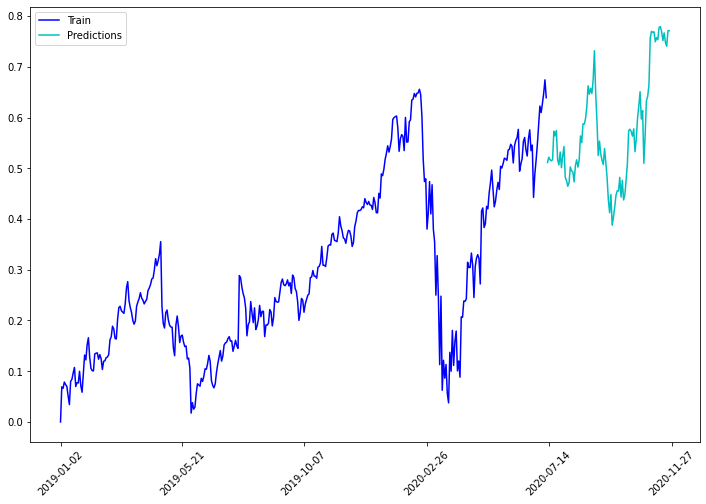

In [ ]:
# plotting the predictions as appended to the training set
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(googl.close[1:int(len(googl["close-1"])*0.8)], color = "b")
plt.plot(googl["pred_N"][int(len(googl["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

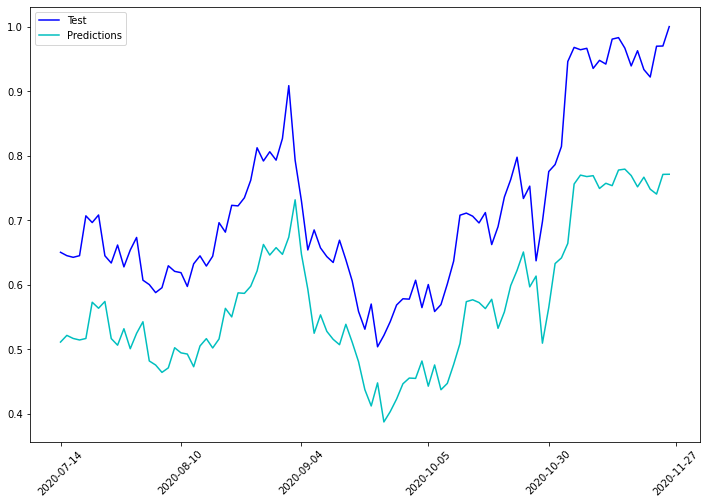

In [ ]:
# plotting the predictions and the test data
# the curves are rather similar
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_googl, color = "b")
plt.plot(googl["pred_N"][int(len(googl["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
# checking the mean squared error
np.sqrt(np.mean(googl["pred_N"][int(len(googl["close-1"])*0.8):] - y_test_googl)**2)

0.14539090361604606

#Alxn

In [ ]:
alxn=df.loc[:,['ALXN']]

In [ ]:
alxn=alxn.rename(columns={"ALXN": "close"})

In [ ]:
# creating a minmaxscaler instance
scaler_alxn = MinMaxScaler(feature_range=(0, 1))
# scaling the close column
alxn['close'] = scaler_alxn.fit_transform(alxn['close'].values.reshape(-1,1))

In [ ]:
# creating a new column in the dataframe that consists of the same values as the scaled close column
alxn["close-1"] = alxn["close"]
# shifting the column 1 days back
alxn["close-1"] = alxn["close-1"].shift(1)
# inspecting the dataframe
alxn.head()

,close,close-1
date,,
2019-01-02,0.342105,NaN
2019-01-03,0.374962,0.342105
2019-01-04,0.463036,0.374962
2019-01-07,0.492546,0.463036
2019-01-08,0.502738,0.492546


In [ ]:
# creating a train and test split (this time using 80% of the data for training)
X_train_alxn = alxn["close-1"][1:int(len(alxn["close-1"])*0.8)]
X_test_alxn = alxn["close-1"][int(len(alxn["close-1"])*0.8):]
y_train_alxn = alxn["close"][1:int(len(alxn["close-1"])*0.8)]
y_test_alxn = alxn["close"][int(len(alxn["close-1"])*0.8):]

In [ ]:
# reshaping the train and test values
X_train_alxn = X_train_alxn.values.reshape(-1,1)
X_test_alxn = X_test_alxn.values.reshape(-1,1)
y_train_alxn = y_train_alxn.values.reshape(-1,1)

##2.1 Random Forest

In [ ]:
# creating a grid for the grid search for the random forest regressor
grid_alxn = {'n_estimators': list(range(10,101,10)),
               'max_features': ['auto', 'sqrt'],
               'max_depth': list(range(10,101,10)),
               'bootstrap': [True, False]}

In [ ]:
# creating a random forest regressor instance
rf_alxn = RandomForestRegressor()
# creating a grid search instance with 5 cross validation splits
search_alxn = GridSearchCV(rf_alxn, grid_alxn, cv=5)

In [ ]:
# fitting the search to the training set
search_alxn.fit(X_train_alxn, y_train_alxn)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
# printing out the best parameters and their score
print(search.best_params_)
print(search.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.9119359460835458


In [ ]:
# creating a regression with the selected parameters
rf_alxn = RandomForestRegressor(bootstrap= True, max_depth = 10, max_features = "sqrt", n_estimators = 60)
# fitting it to the training set
rf_alxn.fit(X_train_alxn, y_train_alxn)
# predicting the values
y_pred_alxn_RF = rf_alxn.predict(X_test_alxn)

In [ ]:
# creating a new column in the dataframe
alxn["pred_RF"] = np.nan
# filling the column with the predicted values
alxn["pred_RF"][int(len(alxn["close-1"])*0.8):] = y_pred_alxn_RF

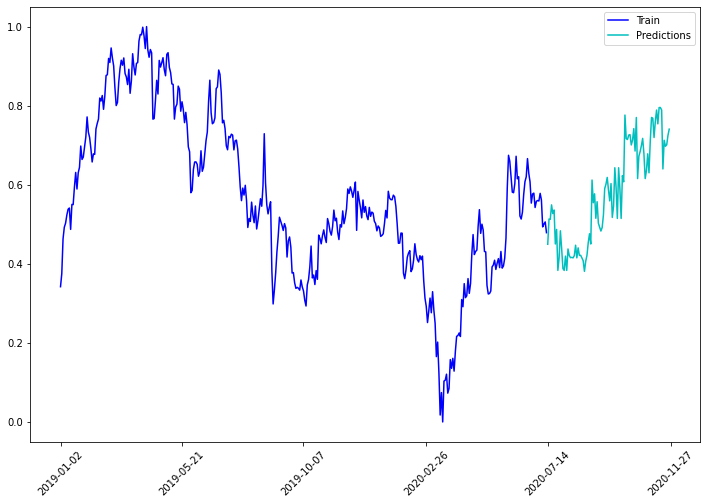

In [ ]:
# plotting the preddictions as appended to the training set
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(alxn.close[:int(len(alxn["close-1"])*0.8)], color = "b")
plt.plot(alxn["pred_RF"][int(len(alxn["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

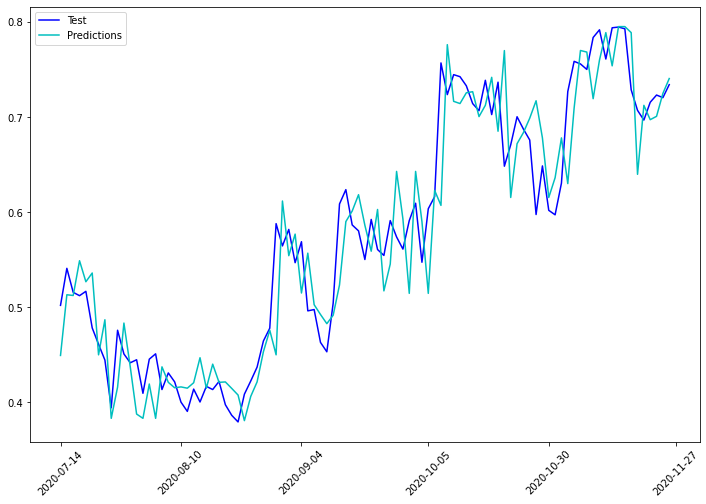

In [ ]:
# plotting the predictions and test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_alxn, color = "b")
plt.plot(alxn["pred_RF"][int(len(alxn["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(alxn["pred_RF"][int(len(alxn["close-1"])*0.8):] - y_test_alxn)**2)

0.0028810171373235493

##2.2 Linear Regression

In [ ]:
# creating a grid search
grid_alxn = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [ ]:
# creating a linear regression instance
lr_alxn = LinearRegression()
# creating a grid search instance with 5 cross validation splits
search_alxn = GridSearchCV(lr_alxn, grid_alxn, cv=5)

In [ ]:
# fitting the grid search to the training data
search_alxn.fit(X_train_alxn, y_train_alxn)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# searching for the best parameters and inspecting the score
print(search.best_params_)
print(search.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.9119359460835458


In [ ]:
# creating a linear regression instance with the chosen parameters
lr_alxn = LinearRegression(copy_X= True, fit_intercept=True,normalize=True)
# fitting it to the training data
lr_alxn.fit(X_train_alxn, y_train_alxn)
# predicting the values
y_pred_alxn_LR = lr_alxn.predict(X_test_alxn)

In [ ]:
# creating a new column in the dataframe
alxn["pred_LR"] = np.nan
# filling it with the predictions
alxn["pred_LR"][int(len(alxn["close-1"])*0.8):] = np.array(y_pred_alxn_LR).squeeze(1)

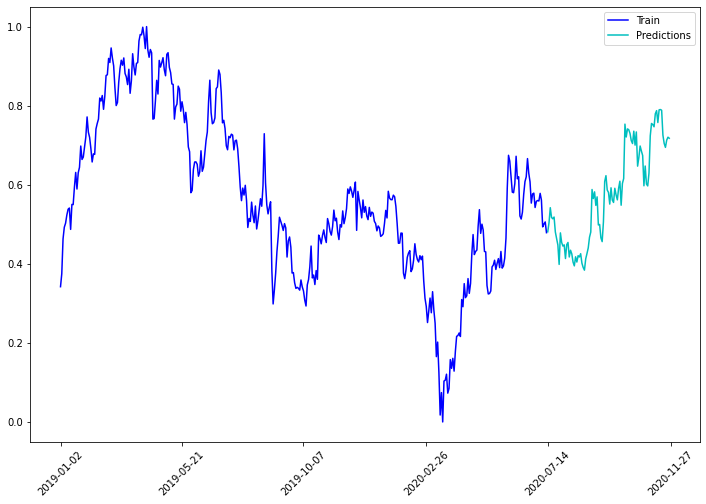

In [ ]:
# plotting the predictions as appended to the training data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(alxn.close[:int(len(alxn["close-1"])*0.8)], color = "b")
plt.plot(alxn["pred_LR"][int(len(alxn["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

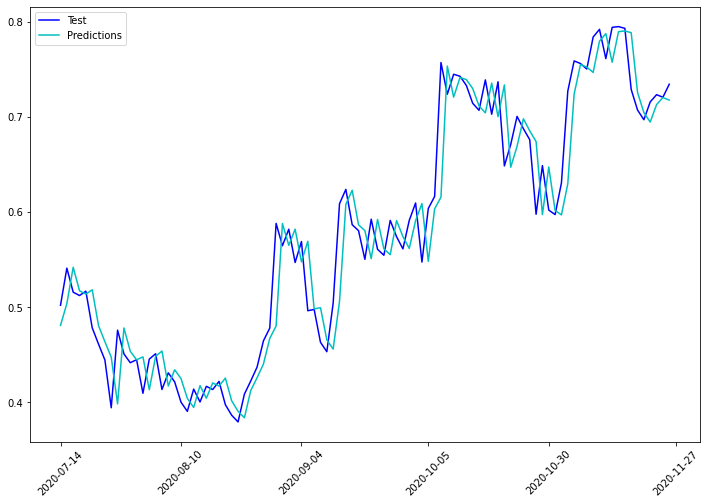

In [ ]:
# plotting the predictions and the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_alxn, color = "b")
plt.plot(alxn["pred_LR"][int(len(alxn["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(alxn["pred_LR"][int(len(alxn["close-1"])*0.8):] - y_test_alxn)**2)

0.0024802825172939914

##3 Neural network for stock predictions

In [ ]:
# reshaping it again to make sure the dimensions are right for the network
X_train_alxn = np.reshape(X_train_alxn, (X_train_alxn.shape[0], 1, 1))
X_test_alxn = np.reshape(X_test_alxn, (X_test_alxn.shape[0], 1, 1))

In [ ]:
# creating a sequential model
model_alxn = Sequential()
# adding the firs tLSTM layer with 128 neurons, 0.2 dropout and recurrent dropout and return_sequences = True (to connect another LSTM layer)
model_alxn.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (1,1)))
# adding another LSTM layer - this time 64 neurons and no returning sequences
model_alxn.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# adding a dropout layer with 0.5 dropout rate
model_alxn.add(layers.Dropout(0.5))
# adding a dense layer with 128 neurons
model_alxn.add(layers.Dense(128, activation = "relu"))
# adding a dense layer with 64 neurons
model_alxn.add(layers.Dense(64, activation = "relu"))
# adding another dropout layer, this time just 0.2 dropout rate
model_alxn.add(layers.Dropout(0.2))
# adding the output layer with one neuron
model_alxn.add(layers.Dense(1))

In [ ]:
# viewing the summary of the model
model_alxn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            66560     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
# creating an early stopping monitor with the patience of 5 periods
stop_alxn = EarlyStopping(monitor = "loss", patience = 5, mode = "min", restore_best_weights=True)
# changing the learning rate of the optimizer
opt_alxn = optimizers.Adam(learning_rate=0.001)

In [ ]:
# compiling the model
model_alxn.compile(loss='mean_squared_error', optimizer=opt_alxn)

In [ ]:
# fitting the model with the batch size of 1 and 50 epochs
history_alxn = model_alxn.fit(X_train_alxn, y_train_alxn, epochs=50, batch_size=1, verbose=1, callbacks = [stop_alxn])

Epoch 1/50
384/384 [==============================] - 5s 5ms/step - loss: 0.0941
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0275
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0194
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0301
Epoch 5/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0240
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0231
Epoch 7/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0185
Epoch 8/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0187
Epoch 9/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0229
Epoch 10/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0182
Epoch 11/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0193
Epoch 12/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0178
Epoch 13/50
384/384 [====

In [ ]:
# predicting the data
y_pred_alxn_N = model_alxn.predict(X_test_alxn)

In [ ]:
# creating an empty column
alxn["pred_N"] = np.nan
# filling it with the predictions
alxn["pred_N"][int(len(alxn["close-1"])*0.8):] = np.array(y_pred_alxn_N).squeeze(1)

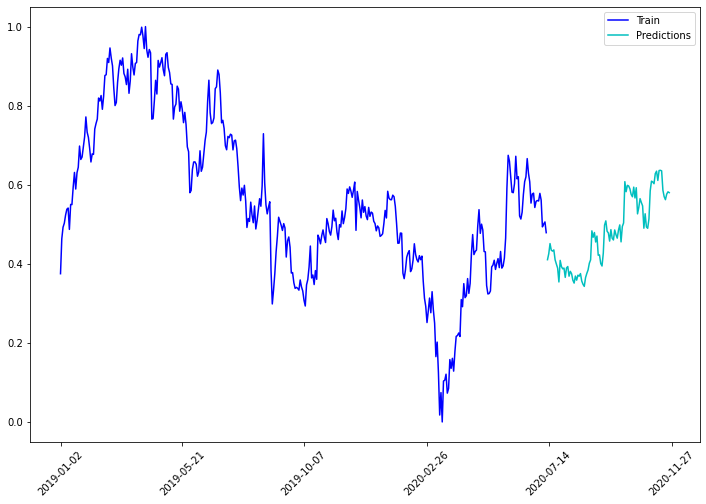

In [ ]:
# plotting the predictions as appended to the training set
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(alxn.close[1:int(len(alxn["close-1"])*0.8)], color = "b")
plt.plot(alxn["pred_N"][int(len(alxn["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

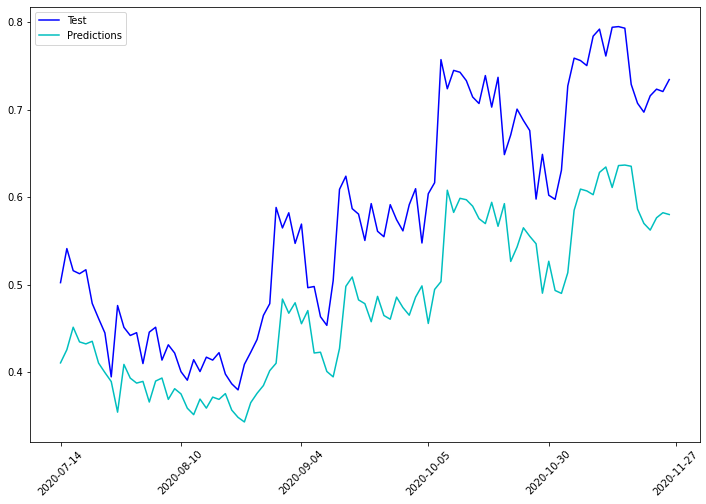

In [ ]:
# plotting the predictions and the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_alxn, color = "b")
plt.plot(alxn["pred_N"][int(len(alxn["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
# checking the mean squared error
np.sqrt(np.mean(alxn["pred_N"][int(len(alxn["close-1"])*0.8):] - y_test_alxn)**2)

0.09991874429862099

#Amazon

In [ ]:
amzn=df.loc[:,['AMZN']]

In [ ]:
amzn=amzn.rename(columns={"AMZN": "close"})

In [ ]:
# creating a minmaxscaler instance
scaler = MinMaxScaler(feature_range=(0, 1))
# scaling the close column
amzn['close'] = scaler.fit_transform(amzn['close'].values.reshape(-1,1))

In [ ]:
# creating a new column in the dataframe that consists of the same values as the scaled close column
amzn["close-1"] = amzn["close"]
# shifting the column 1 days back 
amzn["close-1"] = amzn["close-1"].shift(1)
# inspecting the dataframe
amzn.head()

,close,close-1
date,,
2019-01-02,0.019127,NaN
2019-01-03,0.000000,0.019127
2019-01-04,0.036979,0.000000
2019-01-07,0.063623,0.036979
2019-01-08,0.076951,0.063623


In [ ]:
# creating a train and test split (this time using 80% of the data for training)
X_train_amzn = amzn["close-1"][1:int(len(amzn["close-1"])*0.8)]
X_test_amzn = amzn["close-1"][int(len(amzn["close-1"])*0.8):]
y_train_amzn = amzn["close"][1:int(len(amzn["close-1"])*0.8)]
y_test_amzn = amzn["close"][int(len(amzn["close-1"])*0.8):]

In [ ]:
# reshaping the train and test values
X_train_amzn = X_train_amzn.values.reshape(-1,1)
X_test_amzn = X_test_amzn.values.reshape(-1,1)
y_train_amzn = y_train_amzn.values.reshape(-1,1)

##2.1 Random Forest

In [ ]:
# creating a grid for the grid search for the random forest regressor
grid_amzn = {'n_estimators': list(range(10,101,10)),
               'max_features': ['auto', 'sqrt'],
               'max_depth': list(range(10,101,10)),
               'bootstrap': [True, False]}

In [ ]:
# creating a random forest regressor instance
rf_amzn = RandomForestRegressor()
# creating a grid search instance with 5 cross validation splits
search_amzn = GridSearchCV(rf_amzn, grid_amzn, cv=5)

In [ ]:
# fitting the search to the training set
search_amzn.fit(X_train_amzn, y_train_amzn)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
# printing out the best parameters and their score
print(search.best_params_)
print(search.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.9119359460835458


In [ ]:
# creating a regression with the selected parameters
rf_amzn = RandomForestRegressor(bootstrap= True, max_depth = 10, max_features = "sqrt", n_estimators = 60)
# fitting it to the training set
rf_amzn.fit(X_train_amzn, y_train_amzn)
# predicting the values
y_pred_amzn_RF = rf_amzn.predict(X_test_amzn)

In [ ]:
# creating a new column in the dataframe
amzn["pred_RF"] = np.nan
# filling the column with the predicted values
amzn["pred_RF"][int(len(amzn["close-1"])*0.8):] = y_pred_amzn_RF

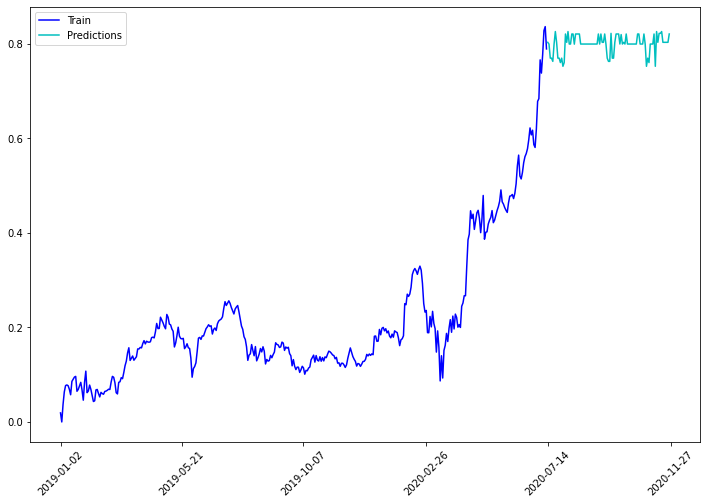

In [ ]:
# plotting the preddictions as appended to the training set - they seem consistent
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(amzn.close[:int(len(amzn["close-1"])*0.8)], color = "b")
plt.plot(amzn["pred_RF"][int(len(amzn["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

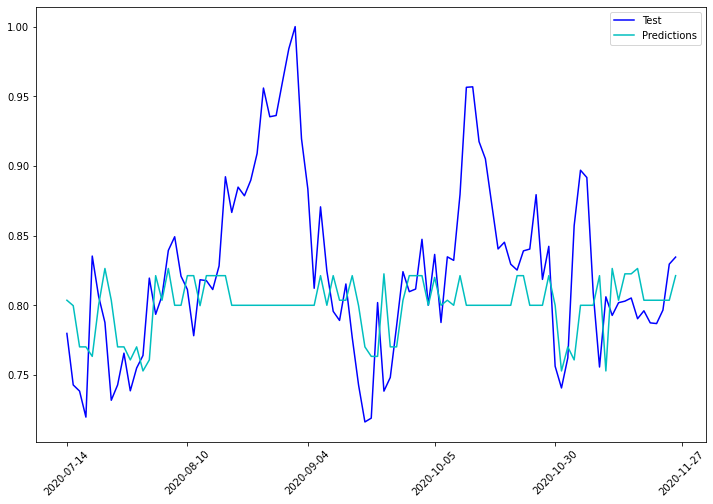

In [ ]:
# plotting the predictions and test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_amzn, color = "b")
plt.plot(amzn["pred_RF"][int(len(amzn["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(amzn["pred_RF"][int(len(amzn["close-1"])*0.8):] - y_test_amzn)**2)

0.02538115487066726

##2.2 Linear Regression

In [ ]:
# creating a grid search
grid_amzn = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [ ]:
# creating a linear regression instance
lr_amzn = LinearRegression()
# creating a grid search instance with 5 cross validation splits
search_amzn = GridSearchCV(lr_amzn, grid_amzn, cv=5)

In [ ]:
# fitting the grid search to the training data
search_amzn.fit(X_train_amzn, y_train_amzn)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# searching for the best parameters and inspecting the score
print(search.best_params_)
print(search.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.9119359460835458


In [ ]:
# creating a linear regression instance with the chosen parameters
lr_amzn = LinearRegression(copy_X= True, fit_intercept=True,normalize=True)
# fitting it to the training data
lr_amzn.fit(X_train_amzn, y_train_amzn)
# predicting the values
y_pred_amzn_LR = lr_amzn.predict(X_test_amzn)

In [ ]:
# creating a new column in the dataframe
amzn["pred_LR"] = np.nan
# filling it with the predictions
amzn["pred_LR"][int(len(amzn["close-1"])*0.8):] = np.array(y_pred_amzn_LR).squeeze(1)

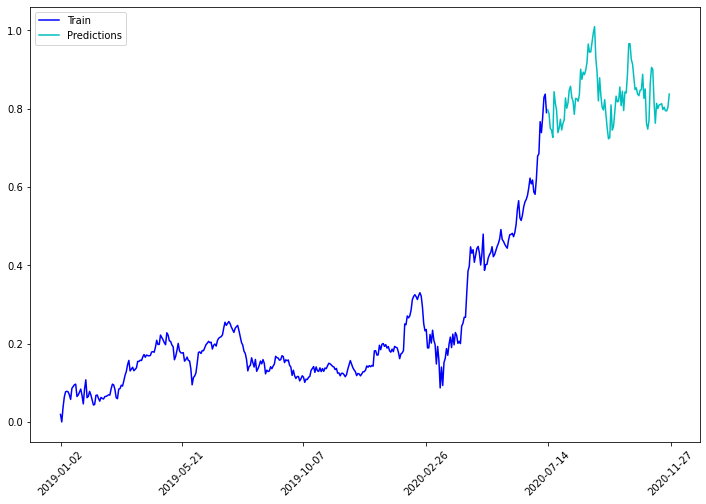

In [ ]:
# plotting the predictions as appended to the training data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(amzn.close[:int(len(amzn["close-1"])*0.8)], color = "b")
plt.plot(amzn["pred_LR"][int(len(amzn["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

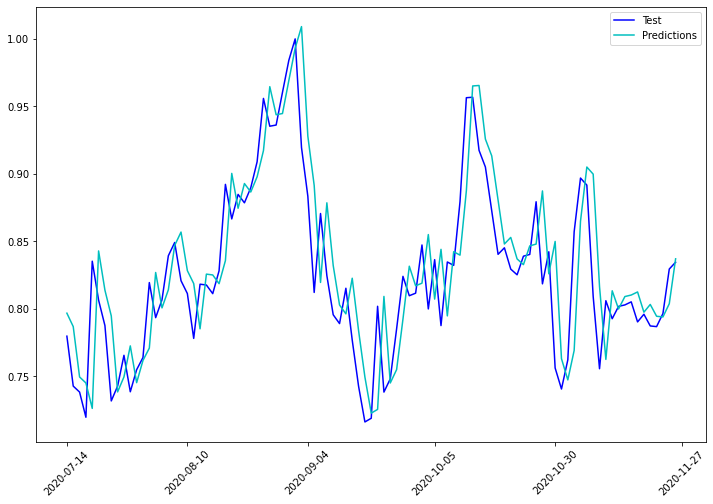

In [ ]:
# plotting the predictions and the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_amzn, color = "b")
plt.plot(amzn["pred_LR"][int(len(amzn["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
np.sqrt(np.mean(amzn["pred_LR"][int(len(amzn["close-1"])*0.8):] - y_test_amzn)**2)

0.007056125334738162

##3 Neural network for stock predictions

In [ ]:
# reshaping it again to make sure the dimensions are right for the network
X_train_amzn = np.reshape(X_train_amzn, (X_train_amzn.shape[0], 1, 1))
X_test_amzn = np.reshape(X_test_amzn, (X_test_amzn.shape[0], 1, 1))

In [ ]:
# creating a sequential model
model_amzn = Sequential()
# adding the firs tLSTM layer with 128 neurons, 0.2 dropout and recurrent dropout and return_sequences = True (to connect another LSTM layer)
model_amzn.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (1,1)))
# adding another LSTM layer - this time 64 neurons and no returning sequences
model_amzn.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# adding a dropout layer with 0.5 dropout rate
model_amzn.add(layers.Dropout(0.5))
# adding a dense layer with 128 neurons
model_amzn.add(layers.Dense(128, activation = "relu"))
# adding a dense layer with 64 neurons
model_amzn.add(layers.Dense(64, activation = "relu"))
# adding another dropout layer, this time just 0.2 dropout rate
model_amzn.add(layers.Dropout(0.2))
# adding the output layer with one neuron
model_amzn.add(layers.Dense(1))

In [ ]:
# viewing the summary of the model
model_amzn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 128)            66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [ ]:
# creating an early stopping monitor with the patience of 5 periods
stop_amzn = EarlyStopping(monitor = "loss", patience = 5, mode = "min", restore_best_weights=True)
# changing the learning rate of the optimizer
opt_amzn = optimizers.Adam(learning_rate=0.001)

In [ ]:
# compiling the model
model_amzn.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
# fitting the model with the batch size of 1 and 50 epochs
history_amzn = model_amzn.fit(X_train_amzn, y_train_amzn, epochs=50, batch_size=1, verbose=1, callbacks = [stop_amzn])

Epoch 1/50
384/384 [==============================] - 5s 5ms/step - loss: 0.0295
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0091
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0113
Epoch 5/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0070
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0090
Epoch 7/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0069
Epoch 8/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0064
Epoch 9/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0065
Epoch 10/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0098
Epoch 11/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0061
Epoch 12/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0071
Epoch 13/50
384/384 [====

In [ ]:
# predicting the data
y_pred_amzn_N = model.predict(X_test_amzn)

In [ ]:
# creating an empty column
amzn["pred_N"] = np.nan
# filling it with the predictions
amzn["pred_N"][int(len(amzn["close-1"])*0.8):] = np.array(y_pred_amzn_N).squeeze(1)

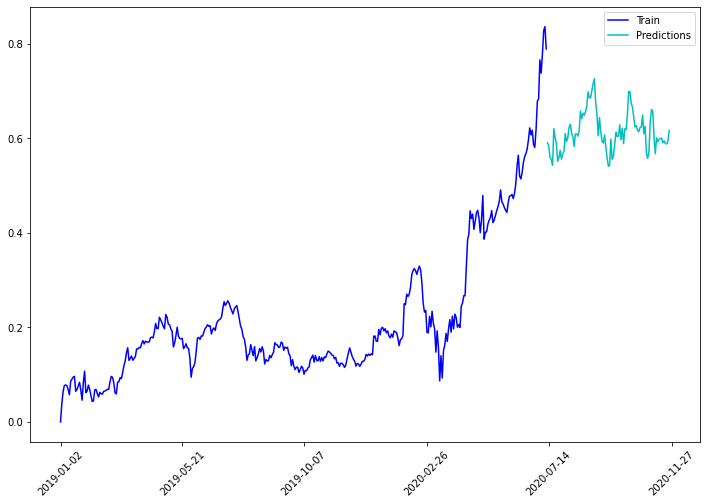

In [ ]:
# plotting the predictions as appended to the training set
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, ticks=[0, int(len(tsla)*0.2),int(len(tsla)*0.4),int(len(tsla)*0.6),int(len(tsla)*0.8),int(len(tsla))], labels = [tsla.index[0],tsla.index[int(len(tsla)*0.2)],tsla.index[int(len(tsla)*0.4)],tsla.index[int(len(tsla)*0.6)],tsla.index[int(len(tsla)*0.8)], tsla.index[-1]])
plt.plot(amzn.close[1:int(len(amzn["close-1"])*0.8)], color = "b")
plt.plot(amzn["pred_N"][int(len(amzn["close-1"])*0.8):], color = "c")
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

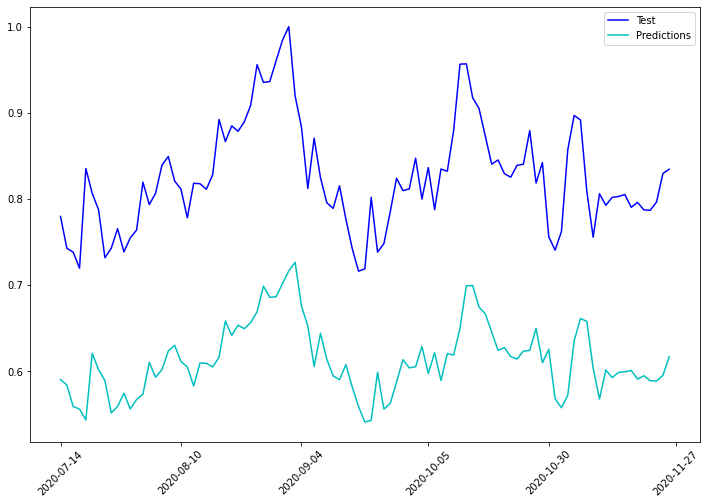

In [ ]:
# plotting the predictions and the test data
plt.figure(figsize=(12,8))
plt.xticks(rotation=45,ticks=[0, int(len(y_test_tsla)*0.2),int(len(y_test_tsla)*0.4),int(len(y_test_tsla)*0.6),int(len(y_test_tsla)*0.8),int(len(y_test_tsla))], labels = [y_test_tsla.index[0],y_test_tsla.index[int(len(y_test_tsla)*0.2)],y_test_tsla.index[int(len(y_test_tsla)*0.4)],y_test_tsla.index[int(len(y_test_tsla)*0.6)],y_test_tsla.index[int(len(y_test_tsla)*0.8)], y_test_tsla.index[-1]])
plt.plot(y_test_amzn, color = "b")
plt.plot(amzn["pred_N"][int(len(amzn["close-1"])*0.8):], color = "c")
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [ ]:
# checking the mean squared error
np.sqrt(np.mean(amzn["pred_N"][int(len(amzn["close-1"])*0.8):] - y_test_amzn)**2)

0.21166998661520278